In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import math
import os

In [103]:
tf.__version__

'2.15.0'

In [104]:
train_marker_path = '../data/train/marker_train_2.jpeg'
label_file_path = '../data/train/image_descriptions.txt'

In [105]:
# Constants
img_size_flat = 90000
img_shape_full = (300, 300, 1)
num_classes = 2

In [106]:
im = cv.imread(train_marker_path)
assert im is not None, "file could not be read, check with os.path.exists()"
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [107]:
# cnt = contours[50]
# cv.drawContours(im, contours, -1, (0,255,0), 3)

In [108]:
# Display the image with the drawn contour
# cv.imshow('image', im)

# Save the image with the drawn contour
cv.imwrite('output_image.jpg', im)

True

In [109]:
# Define a directory for saved files
output_dir = '../data/train'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [110]:
# Initialize a list to keep track of filenames and placeholders for classes
image_descriptions = []

In [111]:
# Define the desired size for all output images
desired_dim = (300, 300)  # 300x300 pixels

In [112]:
# Loop through each contour
for i, cnt in enumerate(contours):
    # Get the bounding rectangle for each contour
    x, y, w, h = cv.boundingRect(cnt)

    # Crop the image using the dimensions of the bounding rectangle
    cropped_image = im[y:y+h, x:x+w]

    # Resize the cropped image to the desired size
    resized_image = cv.resize(cropped_image, desired_dim)

    # Save the numpy array to binary format
    filename = f'image_{i}.npy'
    filepath = os.path.join(output_dir, filename)
    np.save(filepath, resized_image)

    # Record the filename and leave a placeholder for the class label
    image_descriptions.append(f'{filename},')  # Leave the class field empty for manual entry

# Write descriptions to a text file
# description_filepath = os.path.join(output_dir, 'image_descriptions.txt')
# with open(description_filepath, 'w') as f:
#     for description in image_descriptions:
#         f.write(description + '\n')

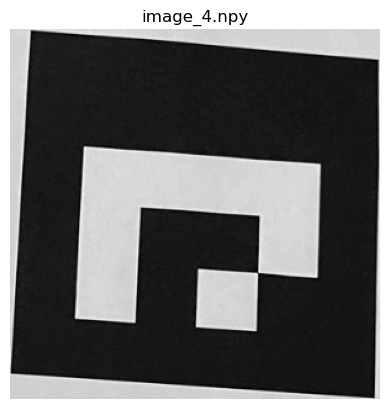

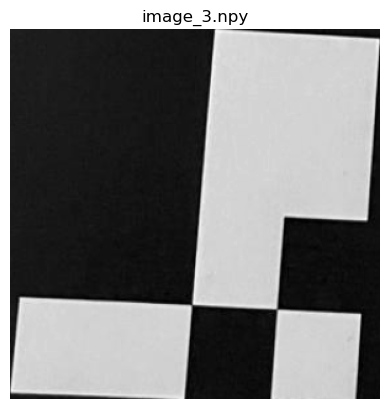

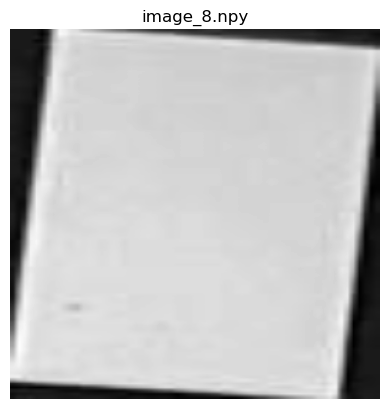

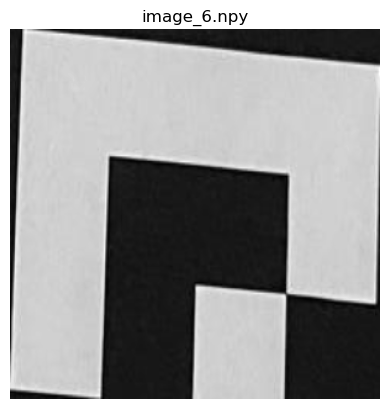

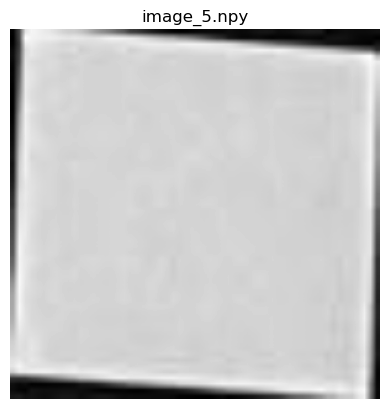

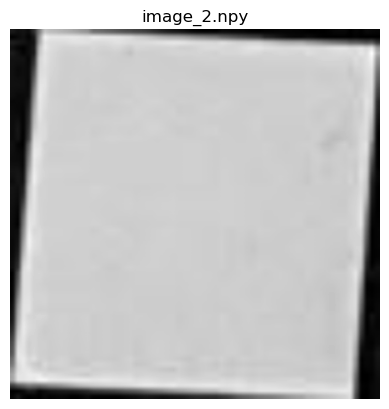

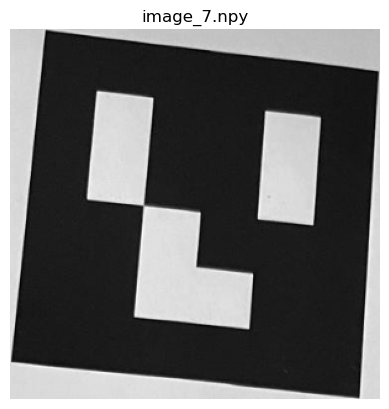

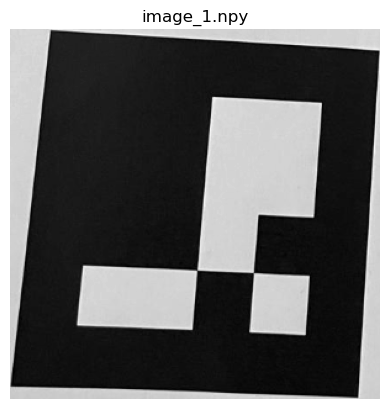

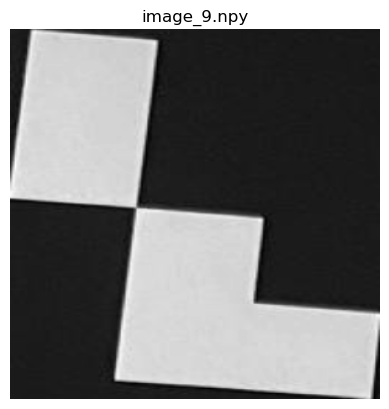

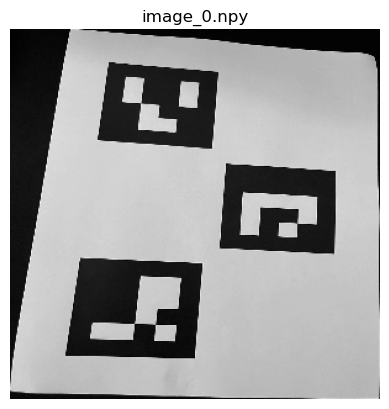

In [113]:
# Get a list of all .npy files in the directory
npy_files = [f for f in os.listdir(output_dir) if f.endswith('.npy')]

images = []
# Loop through each .npy file and visualize the images
for npy_file in npy_files:
    # Load the .npy file
    img_array = np.load(os.path.join(output_dir, npy_file))
    images.append(img_array)

    # Display the image using matplotlib
    plt.imshow(img_array, cmap='gray')
    plt.title(npy_file)
    plt.axis('off')  # Hide axis for clarity
    plt.show()
    # Load images and optionally visualize them


In [114]:
# Assuming all images are the same size and reshaped properly for input to a CNN
images = np.array(images).reshape(-1, 300, 300, 1)  # Reshape for CNN, change shape as necessary

# Start constructing the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
model.add(InputLayer(input_shape=img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the output of the convolutional layers
model.add(Flatten())

# First fully-connected layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected layer with softmax-activation for use in classification.
model.add(Dense(num_classes, activation='softmax'))

# Compile the model (assuming this is for a classification task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [115]:
# Read labels from the text file
labels = {}
with open(label_file_path, 'r') as file:
    for line in file:
        filename, label = line.strip().split(',')
        labels[filename] = int(label)

# Load images and their labels based on the filenames
images = []
image_labels = []
for npy_file in sorted(os.listdir(output_dir)):
    if npy_file.endswith('.npy') and npy_file in labels:
        img_array = np.load(os.path.join(output_dir, npy_file))
        images.append(img_array)
        image_labels.append(labels[npy_file])
        
print("Number of images:", len(images))
print("Number of labels:", len(image_labels))


Number of images: 10
Number of labels: 10


In [116]:
# Convert lists to numpy arrays
images = np.array(images).reshape(-1, 300, 300, 1)  # Adjust the shape according to your CNN input
image_labels = np.array(image_labels)

# Convert labels to one-hot encoding
image_labels = to_categorical(image_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42)

In [117]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=2,
    epochs=5,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)


Epoch 1/5
4/4 [==============================] - 1s 4ms/step - loss: 930.4651 - accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/5
4/4 [==============================] - 0s 4ms/step - loss: 17.1461 - accuracy: 0.8750
Epoch 4/5
4/4 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [119]:
model.predict(X_test)
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 74ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]